In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [4]:
os.listdir('../input/siim-isic-melanoma-classification')

['sample_submission.csv',
 'jpeg',
 'tfrecords',
 'train.csv',
 'test.csv',
 'test',
 'train']

In [4]:
# store the path to the directories with preprocessed png images
train_dir = '../input/siic-isic-224x224-images/train/'
test_dir = '../input/siic-isic-224x224-images/test/'

# load csv files with image name and metadata
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

batch_size = 64
img_size = (224, 224)

### Look at the Training Set

In [6]:
train_per = len(train_df)/(len(test_df)+len(train_df))
test_per = len(test_df)/(len(test_df)+len(train_df))
print("Train-test split: {:.2f} and {:.2f}".format(train_per, test_per))

Train-test split: 0.75 and 0.25


In [7]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
# multiple images come from each patient -- an average of 16 images per patient
train_df.groupby('patient_id')['image_name'].count().mean()

16.111867704280154

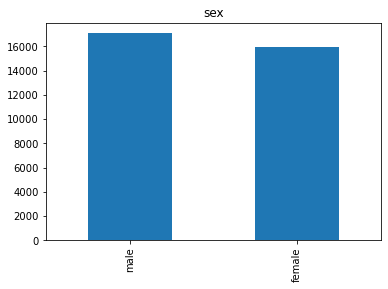

In [9]:
# look at distribution of sex
train_df['sex'].value_counts().plot(kind='bar', title='sex')
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


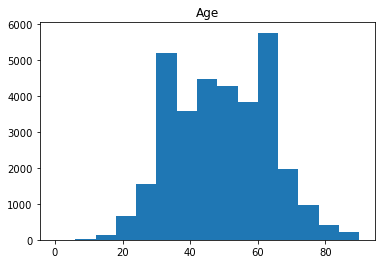

In [10]:
# look at distribution of age
plt.hist(train_df['age_approx'], bins=15)
plt.title('Age')
plt.show()

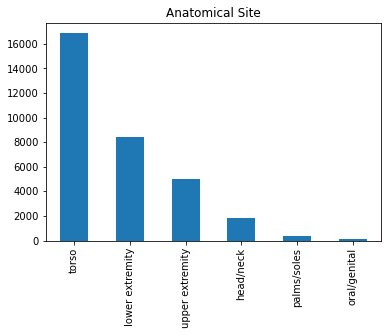

In [11]:
# look at distribution of anatomic site
train_df['anatom_site_general_challenge'].value_counts().plot(kind='bar', title='Anatomical Site')
plt.show()

In [12]:
# look at distribution of benign vs malignant (the target we are predicting)
train_df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

#### We are going to have a class imbalance problem because 98% of the training data is benign and only 2% of the training data is malignant.

### Set Up Data Loading

In [5]:
# Define the Dataset and the DataLoader
class MyDataset(Dataset):
    def __init__(self, dataframe, train=True, transform=None):
        self.df = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df['image_name'][idx]
        label = self.df['target'][idx]
        
        if self.train:
            img_path = train_dir + img_name + '.png'
        else:
            img_path = test_dir + img_name + '.png'
        
        # read in the image
        image = cv2.imread(img_path) # (224, 224, 3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # reorder colors
        image = transforms.ToPILImage()(image) 
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

# do some data augmentation
data_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

trainset = MyDataset(train_df, train=True, transform=data_transform)
testset = MyDataset(test_df, train=False, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

### Visually Inspect the Data

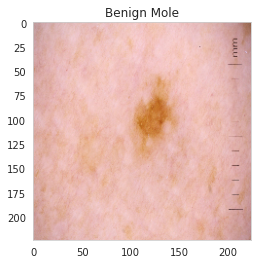

In [115]:
sns.set_style("whitegrid", {'axes.grid' : False})

def imshow(image, title=None):
    np_img = image.numpy()
    if title:
        plt.title(title)
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # [channel, height, width] => [height, width, channel]
    plt.show()
    
data_iter = iter(train_loader) # get a batch of images
images, labels = data_iter.next()

# display a benign moles
imshow(make_grid(images[labels == 0][0], 1, 1), title='Benign Mole')

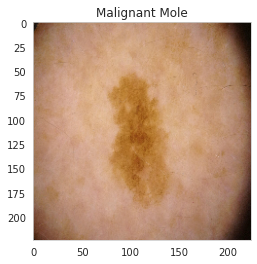

In [116]:
# display a malignant mole
imshow(make_grid(images[labels == 1][0], 1, 1), title='Malignant Mole')